# Load Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
from scipy.integrate import odeint


os.chdir('../')

print(os.getcwd())

/Users/gbemidebe/Documents/GitHub/compositional_model


# 1. MixedResin-SPEEK(CEI)-binder-2

In [2]:


data_orig = pd.read_excel('./data/processed/6.1-vm_lbm-pro-EDI_NaCl.xlsx', sheet_name='MixedResin-SPEEK(CEI)-binder-2', header=0)
data = data_orig.dropna(axis=0, how='any')

In [3]:
data_orig

,time elapsed (min),time (min),Stack voltage (V),Cell voltage (V),Current (A),Feed conductivity (mS/cm),Feed pH,Feed concentration (g/L),Concentrate conductivity (mS/cm),Conc. pH,Concentrate concentration (g/L)
0,0,NaN,NaN,NaN,NaN,9.170,5.72,3.024395,9.21,5.60,3.035775
1,15,0.0,9.089,4.075,0.146,8.420,8.76,2.561735,8.90,8.64,2.911151
2,30,15.0,9.089,3.811,0.138,6.630,8.82,1.973194,10.67,6.95,3.510690
3,31,16.0,9.308,4.006,0.140,NaN,NaN,NaN,NaN,NaN,NaN
4,60,45.0,9.308,4.453,0.089,3.380,8.79,0.985605,13.85,7.55,4.539636
5,61,46.0,8.678,3.904,0.083,NaN,NaN,NaN,NaN,NaN,NaN
6,90,75.0,8.678,4.281,0.051,1.461,8.49,0.424394,15.47,7.20,5.133980
7,91,76.0,8.195,3.896,0.044,NaN,NaN,NaN,NaN,NaN,NaN
8,120,105.0,8.195,4.475,0.026,0.469,7.85,0.125575,16.20,7.57,5.437648
9,121,106.0,7.582,4.009,0.023,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
np.array(data_orig['time elapsed (min)'])

array([  0,  15,  30,  31,  60,  61,  90,  91, 120, 121, 135])

In [5]:
np.array(data_orig['Feed concentration (g/L)'])

array([3.02439513, 2.56173483, 1.97319383,        nan, 0.98560537,
              nan, 0.42439375,        nan, 0.12557464,        nan,
       0.05431178])

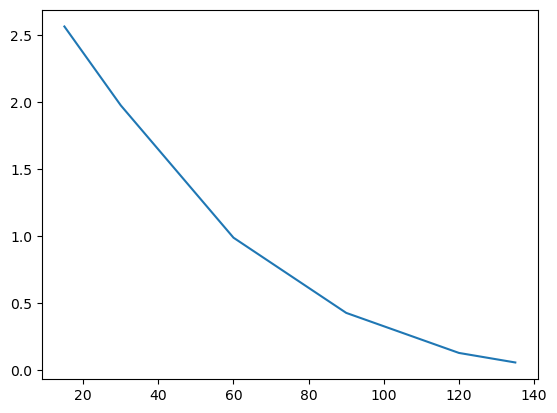

In [6]:
plt.plot(np.array(data['time elapsed (min)']), np.array(data['Feed concentration (g/L)']))

In [7]:
# Execute simulation
MW_Cl, MW_Na = 35.45, 23 # Molecular weight of Cl & Na, g/mol
Cdil0 = data.loc[1, 'Feed concentration (g/L)'] * 1e3/ MW_Cl # Cl in Concentrate inlet (mol/m3)
Cconc0 = data.loc[1, 'Concentrate concentration (g/L)'] * 1e3 / MW_Cl # Cl in Diluate inlet (mol/m3)    

print(f" Cconc0 = {Cconc0:.2f} mol/m3 \n Cdil0 = {Cdil0:.2f} mol/m3")

 Cconc0 = 82.12 mol/m3 
 Cdil0 = 72.26 mol/m3


In [8]:
from source.utils import NaclSolution, DeviceFigure

In [9]:
NaCL = NaclSolution()

In [10]:
Qconc = (50*1e-6) / 60      # Flow rate dil. chamber m^3/s
Qdil = (25*1e-6) / 60       # Flow rate conc. chamber m^3/s
A = 14e-4                   # Cross sectional area of channel m^2
psp = 0.13                  # porosity of compartment
Ldil = 3e-3                 # Diluate channel thickness, m
Lconc = 1e-3                # Concentrate channel thickness, m
km_conc = NaCL.mtc(Q=Qconc, A=A, h=Lconc, N=4, c=Cconc0, p=1) # mass transfer coefficient, m/s
km_dil = NaCL.mtc(Q=Qdil, A=A, h=Ldil, N=4, c=Cdil0, p=1) # mass transfer coefficient, m/s

print(f"km_conc = {km_conc:.2e} m/s \nkm_dil = {km_dil:.2e} m/s")

km_conc = 1.04e-06 m/s 
km_dil = 4.25e-07 m/s


In [11]:
h = Lconc
p = 1
Q = Qconc
N = 4
A = 14e-4
dh = 4 * p / (2 / h + (1 - p) * (8 / h))
interstitial_vel_channel = Q / (p * A * N)

print(f"Lconc = {Lconc:.2e} m \ndh = {dh:.2e} m \ninterstitial_vel_channel = {interstitial_vel_channel:.2e} m/s")
viscosity_ = 0.8899e-3
density_ = 1000
diffusion_ = 1.6e-9

Sc = viscosity_ / (density_ * diffusion_)
Re = density_ * interstitial_vel_channel * dh / viscosity_
Sh = 0.29 * (Re ** 0.5) * (Sc ** 0.33)

Sh * diffusion_ / dh

Lconc = 1.00e-03 m 
dh = 2.00e-03 m 
interstitial_vel_channel = 1.49e-04 m/s


1.0803655985952359e-06

In [12]:
last = len(data_orig)
last

11

In [13]:
psp = 23.8/100
def mk_dil(poros=psp):
    idx = 'Feed concentration (g/L)'
    Inlet = (data_orig.loc[0, idx]*1e3/35.45) # mol/m3
    Outlet = (data_orig.loc[last-1, idx]*1e3/35.45) # mol/m3

    Qdil = (25e-6)/60 # m3/s
    A = 14e-4 # m2
    n = 4

    return ((Inlet - Outlet)/Inlet)*Qdil/(poros*A*n)

mk_dil()*1e4

3.070109612342159

In [14]:
def mk_conc():
    idx = 'Concentrate concentration (g/L)'
    Inlet = (data_orig.loc[0, idx]*1e3/35.45) # mol/m3
    Outlet = (data_orig.loc[last-1, idx]*1e3/35.45) # mol/m3

    Qconc = (50e-6)/60 # m3/s
    A = 14e-4 # m2
    n = 4

    return -1*((Inlet - Outlet)/Inlet)*Qconc/(A*n)

mk_conc()*1e4

1.2180197557906978

Sorption of metal ions in resins is usually diffusion-controlled and, for dilute solutions, it is generally
admitted that external transfer is the rate-controlling process (Helfferich, 1962), the driving force being the concentration gradient through the diffusion film:

Simulation started
Concentration @ Inlet: Diluate - 72.26, Concentrate - 82.12
Simulation completed


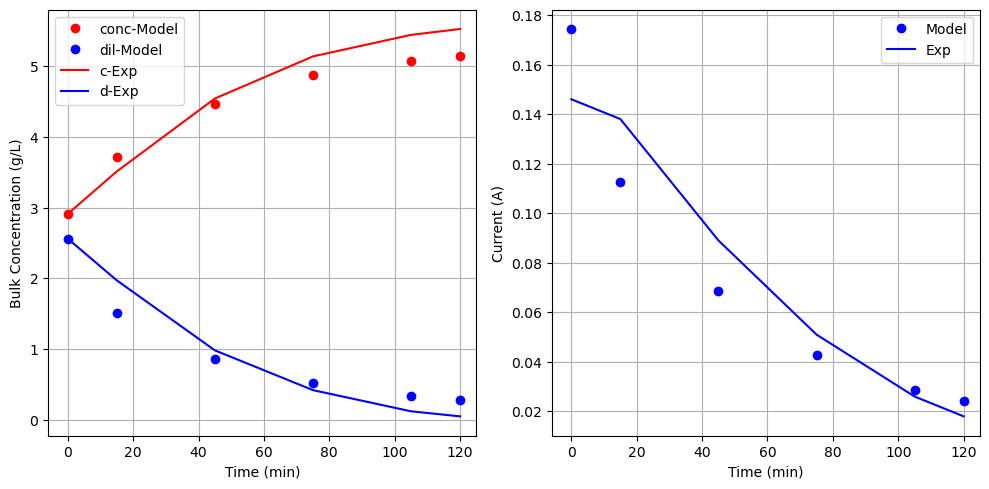

In [15]:
def compute_jEDI(Cconc, Cdil, t, resin, params=[35.45, 4, 3e-3, 1e-3, 14e-4, 4, 298, 1, 1, 0.6, 0.4, 7e-3, 6e-3, 1, 1, 70, 70]):
    F = 96485 # Faraday's constant, C/mol
    R = 8.314 # Gas constant, J/mol-K
    #[MW_Cl, N, Ldil, Lconc, A, Ecell, T, phi, z, t_minus, t_plus, km_dil, km_conc, perm_c, perm_a, Cconc0, Cdil0] = params
    [MW, N, Ldil, Lconc, A, Ecell, T, phi, z, t_minus, t_plus, km_dil, km_conc, perm_c, perm_a, Cconc0, Cdil0] = params

    NaCl = NaclSolution()

    j = 0.001 # A/m2 initial guess
    iteration = 0 # Variable to store the number of iterations
    while True:
        ## A: ******** non-ohmic drop ******** ## 
        # 1. membrane-solution interface
        # km_conc = NaCl.mtc(Q=Qconc, A=A, h=Lconc, c=Cconc, N=N, p=1) # p=1 because it is empty bed
        # km_dil = NaCl.mtc(Q=Qdil, A=A, h=Ldil, c=Cdil, N=N, p=psp) # p=1 because it's not empty bed
        
        # Cwadil = Cdil - phi * j / (z * F * km_dil) * (1 - t_minus)
        # Cwaconc = Cconc + phi * j / (z * F * km_conc) * (1 - t_minus)
        # Cwcdil = Cdil - phi * j / (z * F * km_dil) * (1 - t_plus)
        # Cwcconc = Cconc + phi * j / (z * F * km_conc) * (1 - t_plus)

        Cwadil = Cdil - phi * j * (1 - t_minus)/ (z * F * km_dil) 
        Cwaconc = Cconc + phi * j * (1 - t_minus) / (z * F * km_conc) 
        Cwcdil = Cdil - phi * j * (1 - t_plus)/ (z * F * km_dil) 
        Cwcconc = Cconc + phi * j * (1 - t_plus) / (z * F * km_conc) 
        
        a_conc_wc, a_dil_wc, a_conc_wa, a_dil_wa = NaCl.activity(Cwcconc), NaCl.activity(Cwcdil), NaCl.activity(Cwaconc), NaCl.activity(Cwadil)
        Emem_cem = N * perm_c * (R * T / F) * np.log((a_conc_wc * Cwcconc) / (a_dil_wc * Cwcdil)) #+ N * NaCl.nohm_BL(cDBL=Cwadil, cBULK=Cdil, Temp=T) + N * NaCl.nohm_BL(cDBL=Cwaconc, cBULK=Cconc, Temp=T)
        Emem_aem = N * perm_a * (R * T / F) * np.log((a_conc_wa * Cwaconc) / ( a_dil_wa * Cwadil)) #+ N * NaCl.nohm_BL(cDBL=Cwadil, cBULK=Cdil, Temp=T) + N * NaCl.nohm_BL(cDBL=Cwaconc, cBULK=Cconc, Temp=T)

        Eresin_mem = N * (2*t_minus - 1)*(R * T / F) * np.log((a_dil_wc * Cwcdil)/ (a_dil_wa * Cwadil)) # solution on opposite side of bed

        ## B: ******** ohmic drop ******** ## 
        # 1. diluate, ohm-m2
        R_dil_soln = N * Ldil * 10 / NaCl.solnCond(Cdil) # solution
        R_dil_resin = N * Ldil * 10 / NaCl.resinCond(Cdil, name=resin) # resin
        R_dil = R_dil_soln + R_dil_resin
        # 2. concentrate, ohm-m2
        R_conc = N * Lconc * 10 / NaCl.solnCond(Cdil)
        # 3. membrane
        ra = N * NaCl.AMX(Cdil) # ohm-m2; approx. 2.8e-4
        rc = N * NaCl.CMX(Cdil) # ohm-m2; aprox. 2.5e-4
        # 4. Boundary layer
        EBL_aem = N * (NaCl.ohm_BL(cDBL=Cwadil, cBULK=Cdil, tIEM=1, tBULK=t_minus) + NaCl.ohm_BL(cDBL=Cwaconc, cBULK=Cconc, tIEM=1, tBULK=t_minus))
        EBL_cem = N * (NaCl.ohm_BL(cDBL=Cwcdil, cBULK=Cdil, tIEM=1, tBULK=t_plus) + NaCl.ohm_BL(cDBL=Cwcconc, cBULK=Cconc, tIEM=1, tBULK=t_plus))

        ## current density (A/m2)
        calculated_j = (Ecell - (Emem_cem + Emem_aem + EBL_aem + EBL_cem + Eresin_mem)) / (R_dil + R_conc + ra + rc)
        if abs(calculated_j - j) <= 0.1 or iteration > 10000:
            j = calculated_j
            break

        j = calculated_j
        iteration += 1

    return j # A/m2

def EDI(
                Cconc0 = 70, # Inlet concentrate concentration at inlet at t=0, mol/m3
                Cdil0 = 70, # Inlet diluate concentration at inlet at t=0, mol/m3
                N = 4, # No of cell pairs
                Vconc = 0.25e-3, # concentrate tank volume, m^3; 23-25 mL each
                Vdil = 0.25e-3, # diluate tank volume, m^3
                Qconc = (50*1e-6) / 60, # Flow rate dil. chamber m^3/s
                Qdil = (25*1e-6) / 60, # Flow rate conc. chamber m^3/s
                Da = 5.5e-11, # Avg diffusion coeff of NaCl in AEM (AMX), m^2/s - (M.L. Cerva et al.)
                Dc = 5.5e-11, # Avg diffusion coeff of NaCl in CEM (CMX), m^2/s - (M.L. Cerva et al.)
                La = 0.14e-3, # AEM thickness, m (M.L. Cerva et al.)
                Lc = 0.181e-3, # CEM thickness, m (M.L. Cerva et al.)
                perm_a = 1, # Anionic permselectivity, unitless
                perm_c = 1, # Cationic permselectivity, unitless
                km_dil = 7.4e-04, # diluate mass transfer coefficient, m/s
                km_conc = 1.4e-4, # diluate mass transfer coefficient, m/s
                bt = 1.5e-4, # boundary layer thickness, m (J. Veerman et al. / Journal of Membrane Science 343 (2009) 7–15)
                Ldil = 3e-3, # Diluate channel thickness, m
                Lconc = 1e-3, # Concentrate channel thickness, m
                A  = 14e-4, # Membrane area, m^2
                Ecell = 4, # cell voltage, V
                T_tot = 135 * 60, # Total time s, min * 60
                dt = 1, # Time step, s
                t_eval = None, # array of time, s
                resin_name = 'Mixed-SPEEK', # name of resin
                dp = 570e-6, # resin particle diameter, m  570 ± 50 μm
                kp = 5e-6, # mass transfer coefficient, m/s
                psp = 0.238, # porosity of the resin chamber
                T = 20+273, # Temperature K,
                show_plot = False, # show plot or not
                show_exp=False, # show experimental data or not
                data=None): # Time step, s
    # Constants
    z = 1 # No of electrons transferred
    t_minus, t_plus = 0.61, 0.39 # unitless
    F = 96485 # Faraday's constant, C/mol
    # variables
    Vk_d, Vk_c = A*Ldil, A*Lconc # Diluate & Concentrate compartment volume, m^3
    t_a = 0.5*(perm_a + 1) # unitless
    t_c = 0.5*(perm_c + 1) # unitless
    phi = t_c - (1 - t_a) # Current efficiency
    # set as global variables
    keys = [MW_Cl, N, Ldil, Lconc, A, Ecell, T, phi, z, t_minus, t_plus, km_dil, km_conc, perm_c, perm_a, Cconc0, Cdil0]
    NaCl_m = NaclSolution()

    def dCdt(C, t):
        '''
            params:
                Cconc: Concentrate concentration at outlet
                Cdil: Concentrate concentration at outlet
                Cconc_in: Concentrate concentration at inlet
                Cdil_in: Diluate concentration at inlet
            return:
                DconcDt: 1st diff of Concentrate concentration wrt time
                DdilDt: 1st diff of Diluate concentration wrt time
                Dconc_inDt: 1st diff of Conc concentratn wrt time @ inlet
                Ddil_inDt: 1st diff of Diluate concentration wrt time @ inlet

        '''
        # unpacking the concentrations (mol/m3) array
        Cconc, Cdil, Cdilresin, Cconc_in, Cdil_in = C
        
        # current density in A/m2
        j = compute_jEDI(Cconc=Cconc, Cdil=Cdil, t=t, resin=resin_name, params=keys) 
     
        # concentrations at the membrane-solution interface
        # km_conc = NaCl_m.mtc(Q=Qconc, A=A, h=Lconc, c=Cconc, N=N, p=1) # p=1 because it is empty bed
        # km_dil = NaCl_m.mtc(Q=Qdil, A=A, h=Ldil, c=Cdil, N=N, p=psp) # p=psi because it isnt empty 
        Cwadil = Cdil - phi * j * (1 - t_minus) / (z * F * km_dil) 
        Cwaconc = Cconc + phi * j * (1 - t_minus)/ (z * F * km_conc) 
        Cwcdil = Cdil - phi * j * (1 - t_plus)/ (z * F * km_dil) 
        Cwcconc = Cconc + phi * j * (1 - t_plus) / (z * F * km_conc) 

        # ************ differential equations for the concentrations ************ #
        # bulk solution in concentrate compartment
        DconcDt = (Qconc * (Cconc_in - Cconc) + N * phi * j * A / (z * F)
                        - N * A * Da * (Cwaconc - Cwadil) / La
                        - N * A * Dc * (Cwcconc - Cwcdil) / Lc) / (N * Vk_c) # mol/m3-s
        
        # resin in the diluate compartment
        DdilresinDt = 6*(kp/dp) * (Cdil - Cdilresin) # mol/m3-s
        # bulk solution in diluate compartment
        DdilDt = ((Qdil * (Cdil_in - Cdil)) - N*(1-psp)*Vk_d*DdilresinDt - (N * phi * j * A / (z * F))
                        + (N * A * Da * (Cwaconc - Cwadil) / La)
                        + (N * A * Dc * (Cwcconc - Cwcdil) / Lc)) / (N * psp * Vk_d) # mol/m3-s
  
        Dconc_inDt = Qconc * (Cconc - Cconc_in)/Vconc # mol/m3-s, concentrate inlet
        Ddil_inDt = Qdil * (Cdil - Cdil_in)/Vdil # mol/m3-s, diluate inlet

        return [DconcDt, DdilDt, DdilresinDt, Dconc_inDt, Ddil_inDt]


    #**************************************Solve Equations**************************************
    # Initial conditions
    initial_conditions = [Cconc0, Cdil0, 0, Cconc0, Cdil0] # Initial conditions for the ODEs

    # Parameters
    print('Simulation started')
    # solve
    print(f'Concentration @ Inlet: Diluate - {Cdil0:.2f}, Concentrate - {Cconc0:.2f}')
    
    if t_eval is None:
        teval = np.arange(0, T_tot+(dt/dt), dt)
    else:
        teval = t_eval

    C = odeint(func=dCdt, y0=np.array(initial_conditions), t=teval)
    print('Simulation completed')


    # **************************************Plot Results**************************************
    createFig = DeviceFigure()
    I=createFig.EDI(C = C, teval=teval, resin_name = resin_name, param = keys, show_exp = show_exp, show_plot = show_plot, data = data, jcompute=compute_jEDI, xlim=(T_tot/60) + 5)

    return C, I, teval, keys

       
ConcEff, current, teval, params = EDI(  Ecell = 4, resin_name = 'Mixed-CEI', Da=5.5e-11, Dc=5.5e-11,
                                        Cconc0 = Cconc0, Cdil0 = Cdil0, psp = 23.8/100,
                                        kp = 5e-6, km_dil = mk_dil(), km_conc = mk_conc(), 
                                        show_exp = True, data = data, show_plot = True,
                                        T_tot = 120*60, dt = 15*60, t_eval = data['time (min)'].values * 60 
                                        )

# 2. MixedResin-PE-binder-2

In [16]:
data_orig = pd.read_excel('./data/processed/6.1-vm_lbm-pro-EDI_NaCl.xlsx', sheet_name='MixedResin-PE-binder-2', header=0)
data = data_orig.dropna(axis=0, how='any')

In [17]:
data_orig

,time elapsed (min),time (min),Stack voltage (V),Cell voltage (V),Current (A),Feed conductivity (mS/cm),Feed pH,Feed concentration (g/L),Concentrate conductivity (mS/cm),Conc. pH,Concentrate concentration (g/L)
0,0,NaN,NaN,NaN,NaN,9.180,5.83,3.045433,5.94,9.16,3.035381
1,15,0.0,9.061,4.035,0.104,8.680,11.15,2.678262,3.48,8.94,2.929363
2,30,15.0,9.061,3.969,0.098,7.260,11.01,2.249724,6.01,10.24,3.385553
3,31,16.0,9.110,4.002,0.098,NaN,NaN,NaN,NaN,NaN,NaN
4,60,45.0,9.110,4.017,0.081,4.750,10.81,1.473587,9.66,12.53,4.245788
5,61,46.0,9.072,3.989,0.081,NaN,NaN,NaN,NaN,NaN,NaN
6,92,77.0,9.072,4.140,0.056,2.480,10.59,0.783912,10.08,14.58,4.907146
7,93,78.0,8.891,3.974,0.056,NaN,NaN,NaN,NaN,NaN,NaN
8,122,107.0,8.891,4.221,0.034,1.116,10.32,0.350284,10.30,15.75,5.326576
9,123,108.0,8.595,3.951,0.034,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Execute simulation
MW_Cl, MW_Na = 35.45, 23 # Molecular weight of Cl & Na, g/mol
Cdil0 = data.loc[1, 'Feed concentration (g/L)'] * 1e3/ MW_Cl # Cl in Concentrate inlet (mol/m3)
Cconc0 = data.loc[1, 'Concentrate concentration (g/L)'] * 1e3 / MW_Cl # Cl in Diluate inlet (mol/m3)    

print(f" Cconc0 = {Cconc0:.2f} mol/m3 \n Cdil0 = {Cdil0:.2f} mol/m3")

 Cconc0 = 82.63 mol/m3 
 Cdil0 = 75.55 mol/m3


In [19]:
NaCL = NaclSolution()

In [20]:
last = len(data_orig)
last

11

In [21]:
psp = 26.5/100
def mk_dil(poros=psp):
    idx = 'Feed concentration (g/L)'
    Inlet = (data_orig.loc[0, idx]*1e3/35.45) # mol/m3
    Outlet = (data_orig.loc[last-1, idx]*1e3/35.45) # mol/m3

    Qdil = (25e-6)/60 # m3/s
    A = 14e-4 # m2
    n = 4

    return ((Inlet - Outlet)/Inlet)*Qdil/(poros*A*n)

mk_dil()*1e4

2.787863308718791

In [22]:
def mk_conc():
    idx = 'Concentrate concentration (g/L)'
    Inlet = (data_orig.loc[0, idx]*1e3/35.45) # mol/m3
    Outlet = (data_orig.loc[last-1, idx]*1e3/35.45) # mol/m3

    Qconc = (50e-6)/60 # m3/s
    A = 14e-4 # m2
    n = 4

    return -1*((Inlet - Outlet)/Inlet)*Qconc/(A*n)

mk_conc()*1e4

1.2863709169137179

Sorption of metal ions in resins is usually diffusion-controlled and, for dilute solutions, it is generally
admitted that external transfer is the rate-controlling process (Helfferich, 1962), the driving force being the concentration gradient through the diffusion film:

Simulation started
Concentration @ Inlet: Diluate - 75.55, Concentrate - 82.63
Simulation completed


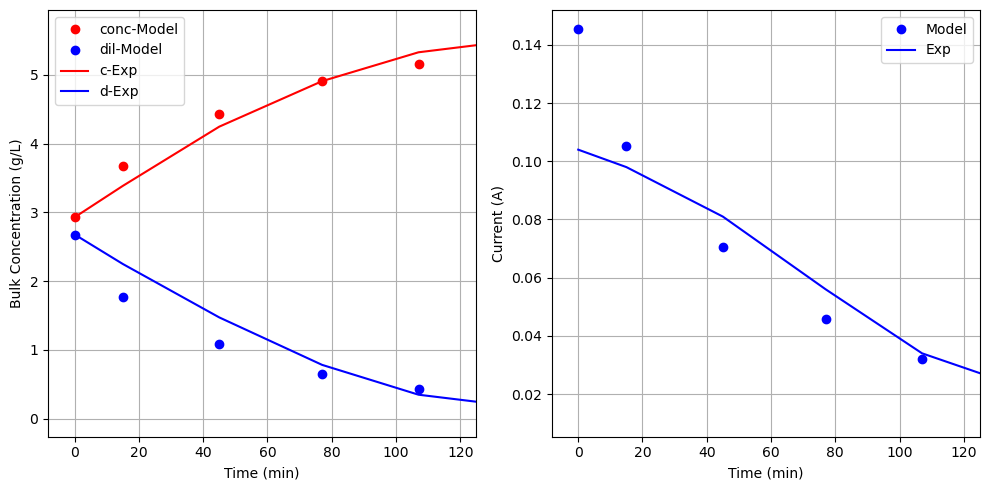

In [23]:
def compute_jEDI(Cconc, Cdil, t, resin, params=[35.45, 4, 3e-3, 1e-3, 14e-4, 4, 298, 1, 1, 0.6, 0.4, 7e-3, 6e-3, 1, 1, 70, 70]):
    F = 96485 # Faraday's constant, C/mol
    R = 8.314 # Gas constant, J/mol-K
    #[MW_Cl, N, Ldil, Lconc, A, Ecell, T, phi, z, t_minus, t_plus, km_dil, km_conc, perm_c, perm_a, Cconc0, Cdil0] = params
    [MW, N, Ldil, Lconc, A, Ecell, T, phi, z, t_minus, t_plus, km_dil, km_conc, perm_c, perm_a, Cconc0, Cdil0] = params

    NaCl = NaclSolution()

    j = 0.001 # A/m2 initial guess
    iteration = 0 # Variable to store the number of iterations
    while True:
        ## A: ******** non-ohmic drop ******** ## 
        # 1. membrane-solution interface
        # km_conc = NaCl.mtc(Q=Qconc, A=A, h=Lconc, c=Cconc, N=N, p=1) # p=1 because it is empty bed
        # km_dil = NaCl.mtc(Q=Qdil, A=A, h=Ldil, c=Cdil, N=N, p=psp) # p=1 because it's not empty bed
        
        Cwadil = Cdil - phi * j / (z * F * km_dil) * (1 - t_minus)
        Cwaconc = Cconc + phi * j / (z * F * km_conc) * (1 - t_minus)
        Cwcdil = Cdil - phi * j / (z * F * km_dil) * (1 - t_plus)
        Cwcconc = Cconc + phi * j / (z * F * km_conc) * (1 - t_plus)
        
        a_conc_wc, a_dil_wc, a_conc_wa, a_dil_wa = NaCl.activity(Cwcconc), NaCl.activity(Cwcdil), NaCl.activity(Cwaconc), NaCl.activity(Cwadil)
        Emem_cem = N * perm_c * (R * T / F) * np.log((a_conc_wc * Cwcconc) / (a_dil_wc * Cwcdil)) #+ N * NaCl.nohm_BL(cDBL=Cwadil, cBULK=Cdil, Temp=T) + N * NaCl.nohm_BL(cDBL=Cwaconc, cBULK=Cconc, Temp=T)
        Emem_aem = N * perm_a * (R * T / F) * np.log((a_conc_wa * Cwaconc) / ( a_dil_wa * Cwadil)) #+ N * NaCl.nohm_BL(cDBL=Cwadil, cBULK=Cdil, Temp=T) + N * NaCl.nohm_BL(cDBL=Cwaconc, cBULK=Cconc, Temp=T)

        Eresin_mem = N * (2*t_minus - 1)*(R * T / F) * np.log((a_dil_wc * Cwcdil)/ (a_dil_wa * Cwadil)) # solution on opposite side of bed

        ## B: ******** ohmic drop ******** ## 
        # 1. diluate, ohm-m2
        R_dil_soln = N * Ldil * 10 / NaCl.solnCond(Cdil) # solution
        R_dil_resin = N * Ldil * 10 / NaCl.resinCond(Cdil, name=resin) # resin
        R_dil = R_dil_soln + R_dil_resin
        # 2. concentrate, ohm-m2
        R_conc = N * Lconc * 10 / NaCl.solnCond(Cdil)
        # 3. membrane
        ra = N * NaCl.AMX(Cdil) # ohm-m2; approx. 2.8e-4
        rc = N * NaCl.CMX(Cdil) # ohm-m2; aprox. 2.5e-4
        # 4. Boundary layer
        EBL_aem = N * (NaCl.ohm_BL(cDBL=Cwadil, cBULK=Cdil, tIEM=1, tBULK=t_minus) + NaCl.ohm_BL(cDBL=Cwaconc, cBULK=Cconc, tIEM=1, tBULK=t_minus))
        EBL_cem = N * (NaCl.ohm_BL(cDBL=Cwcdil, cBULK=Cdil, tIEM=1, tBULK=t_plus) + NaCl.ohm_BL(cDBL=Cwcconc, cBULK=Cconc, tIEM=1, tBULK=t_plus))

        ## current density (A/m2)
        calculated_j = (Ecell - (Emem_cem + Emem_aem + EBL_aem + EBL_cem + Eresin_mem)) / (R_dil + R_conc + ra + rc)
        if abs(calculated_j - j) <= 0.1 or iteration > 10000:
            j = calculated_j
            break

        j = calculated_j
        iteration += 1

    return j # A/m2

def EDI(
                Cconc0 = 70, # Inlet concentrate concentration at inlet at t=0, mol/m3
                Cdil0 = 70, # Inlet diluate concentration at inlet at t=0, mol/m3
                N = 4, # No of cell pairs
                Vconc = 0.25e-3, # concentrate tank volume, m^3; 23-25 mL each
                Vdil = 0.25e-3, # diluate tank volume, m^3
                Qconc = (50*1e-6) / 60, # Flow rate dil. chamber m^3/s
                Qdil = (25*1e-6) / 60, # Flow rate conc. chamber m^3/s
                Da = 5.5e-11, # Avg diffusion coeff of NaCl in AEM (AMX), m^2/s - (M.L. Cerva et al.)
                Dc = 5.5e-11, # Avg diffusion coeff of NaCl in CEM (CMX), m^2/s - (M.L. Cerva et al.)
                La = 0.14e-3, # AEM thickness, m (M.L. Cerva et al.)
                Lc = 0.181e-3, # CEM thickness, m (M.L. Cerva et al.)
                perm_a = 1, # Anionic permselectivity, unitless
                perm_c = 1, # Cationic permselectivity, unitless
                km_dil = 7.4e-04, # diluate mass transfer coefficient, m/s
                km_conc = 1.4e-4, # diluate mass transfer coefficient, m/s
                bt = 1.5e-4, # boundary layer thickness, m (J. Veerman et al. / Journal of Membrane Science 343 (2009) 7–15)
                Ldil = 3e-3, # Diluate channel thickness, m
                Lconc = 1e-3, # Concentrate channel thickness, m
                A  = 14e-4, # Membrane area, m^2
                Ecell = 4, # cell voltage, V
                T_tot = 135 * 60, # Total time s, min * 60
                dt = 1, # Time step, s
                t_eval = None, # array of time, s
                resin_name = 'Mixed-SPEEK', # name of resin
                dp = 570e-6, # resin particle diameter, m  570 ± 50 μm
                kp = 5e-6, # mass transfer coefficient, m/s
                psp = 0.238, # porosity of the resin chamber
                T = 20+273, # Temperature K,
                show_plot = False, # show plot or not
                show_exp=False, # show experimental data or not
                data=None): # Time step, s
    # Constants
    z = 1 # No of electrons transferred
    t_minus, t_plus = 0.61, 0.39 # unitless
    F = 96485 # Faraday's constant, C/mol
    # variables
    Vk_d, Vk_c = A*Ldil, A*Lconc # Diluate & Concentrate compartment volume, m^3
    t_a = 0.5*(perm_a + 1) # unitless
    t_c = 0.5*(perm_c + 1) # unitless
    phi = t_c - (1 - t_a) # Current efficiency
    # set as global variables
    keys = [MW_Cl, N, Ldil, Lconc, A, Ecell, T, phi, z, t_minus, t_plus, km_dil, km_conc, perm_c, perm_a, Cconc0, Cdil0]
    NaCl_m = NaclSolution()

    def dCdt(C, t):
        '''
            params:
                Cconc: Concentrate concentration at outlet
                Cdil: Concentrate concentration at outlet
                Cconc_in: Concentrate concentration at inlet
                Cdil_in: Diluate concentration at inlet
            return:
                DconcDt: 1st diff of Concentrate concentration wrt time
                DdilDt: 1st diff of Diluate concentration wrt time
                Dconc_inDt: 1st diff of Conc concentratn wrt time @ inlet
                Ddil_inDt: 1st diff of Diluate concentration wrt time @ inlet

        '''
        # unpacking the concentrations (mol/m3) array
        Cconc, Cdil, Cdilresin, Cconc_in, Cdil_in = C
        
        # current density in A/m2
        j = compute_jEDI(Cconc=Cconc, Cdil=Cdil, t=t, resin=resin_name, params=keys) 
     
        # concentrations at the membrane-solution interface
        # km_conc = NaCl_m.mtc(Q=Qconc, A=A, h=Lconc, c=Cconc, N=N, p=1) # p=1 because it is empty bed
        # km_dil = NaCl_m.mtc(Q=Qdil, A=A, h=Ldil, c=Cdil, N=N, p=psp) # p=psi because it isnt empty 
        Cwadil = Cdil - phi * j / (z * F * km_dil) * (1 - t_minus)
        Cwaconc = Cconc + phi * j / (z * F * km_conc) * (1 - t_minus)
        Cwcdil = Cdil - phi * j / (z * F * km_dil) * (1 - t_plus)
        Cwcconc = Cconc + phi * j / (z * F * km_conc) * (1 - t_plus)

        # ************ differential equations for the concentrations ************ #
        # bulk solution in concentrate compartment
        DconcDt = (Qconc * (Cconc_in - Cconc) + N * phi * j * A / (z * F)
                        - N * A * Da * (Cwaconc - Cwadil) / La
                        - N * A * Dc * (Cwcconc - Cwcdil) / Lc) / (N * Vk_c) # mol/m3-s
        
        # resin in the diluate compartment
        DdilresinDt = 6*(kp/dp) * (Cdil - Cdilresin) # mol/m3-s
        # bulk solution in diluate compartment
        DdilDt = ((Qdil * (Cdil_in - Cdil)) - (1-psp)*Vk_d*DdilresinDt - (N * phi * j * A / (z * F))
                        + (N * A * Da * (Cwaconc - Cwadil) / La)
                        + (N * A * Dc * (Cwcconc - Cwcdil) / Lc)) / (N * psp * Vk_d) # mol/m3-s
  
        Dconc_inDt = Qconc * (Cconc - Cconc_in)/Vconc # mol/m3-s, concentrate inlet
        Ddil_inDt = Qdil * (Cdil - Cdil_in)/Vdil # mol/m3-s, diluate inlet

        return [DconcDt, DdilDt, DdilresinDt, Dconc_inDt, Ddil_inDt]


    #**************************************Solve Equations**************************************
    # Initial conditions
    initial_conditions = [Cconc0, Cdil0, Cdil0, Cconc0, Cdil0] # Initial conditions for the ODEs

    # Parameters
    print('Simulation started')
    # solve
    print(f'Concentration @ Inlet: Diluate - {Cdil0:.2f}, Concentrate - {Cconc0:.2f}')
    
    if t_eval is None:
        teval = np.arange(0, T_tot+(dt/dt), dt)
    else:
        teval = t_eval

    C = odeint(func=dCdt, y0=np.array(initial_conditions), t=teval)
    print('Simulation completed')


    # **************************************Plot Results**************************************
    createFig = DeviceFigure()
    I=createFig.EDI(C = C, teval=teval, resin_name = resin_name, param = keys, show_exp = show_exp, show_plot = show_plot, data = data, jcompute=compute_jEDI, xlim=(T_tot/60) + 5)

    return C, I, teval, keys

       
ConcEff, current, teval, params = EDI(  Ecell = 4, resin_name = 'Mixed-PE', Da=5.5e-11, Dc=5.5e-11,
                                        Cconc0 = Cconc0, Cdil0 = Cdil0, psp = 26.5/100,
                                        kp = 4e-6, km_dil = mk_dil(), km_conc = mk_conc(), 
                                        show_exp = True, data = data, show_plot = True,
                                        T_tot = 120*60, dt = 15*60, t_eval = data['time (min)'].values * 60 
                                        )

# 3. AER-SPEEK(CEI)-binder-2

In [24]:


data_orig = pd.read_excel('./data/processed/6.1-vm_lbm-pro-EDI_NaCl.xlsx', sheet_name='AER_Resin-SPEEK(CEI)-binder-2', header=0)
data = data_orig.dropna(axis=0, how='any')

In [25]:
data_orig

,time elapsed (min),time (min),Stack voltage (V),Cell voltage (V),Current (A),Feed conductivity (mS/cm),Feed pH,Feed concentration (g/L),Concentrate conductivity (mS/cm),Conc. pH,Concentrate concentration (g/L)
0,0,NaN,NaN,NaN,NaN,9.1300,5.63,3.011023,9.17,5.56,3.013884
1,15,0.0,8.645,4.002,0.192,8.6300,8.92,2.701598,8.92,9.04,2.920419
2,30,15.0,8.645,4.249,0.168,6.3100,9.01,1.932361,11.24,8.70,3.707479
3,31,16.0,8.272,3.911,0.157,NaN,NaN,NaN,NaN,NaN,NaN
4,60,45.0,8.272,4.202,0.086,2.6600,8.67,0.810752,14.61,8.22,4.844255
5,61,46.0,7.960,3.901,0.082,NaN,NaN,NaN,NaN,NaN,NaN
6,90,75.0,7.960,4.158,0.037,0.8500,7.93,0.254380,16.17,8.10,5.370352
7,91,76.0,7.664,3.891,0.037,NaN,NaN,NaN,NaN,NaN,NaN
8,120,105.0,7.664,4.192,0.018,0.1863,7.34,0.042786,16.67,8.06,5.616354
9,121,106.0,7.417,3.981,0.018,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
np.array(data_orig['time elapsed (min)'])

array([  0,  15,  30,  31,  60,  61,  90,  91, 120, 121, 135])

In [27]:
np.array(data_orig['Feed concentration (g/L)'])

array([3.01102272, 2.70159756, 1.93236099,        nan, 0.8107522 ,
              nan, 0.25437981,        nan, 0.04278557,        nan,
       0.01024849])

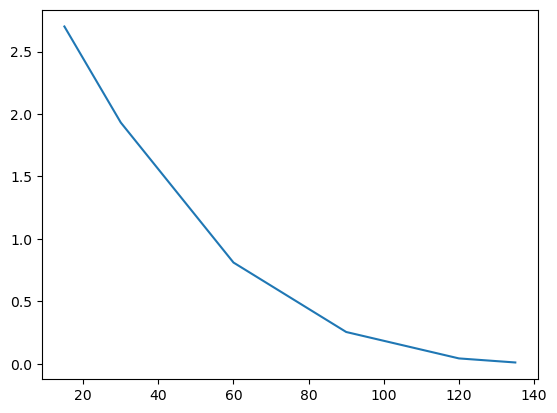

In [28]:
plt.plot(np.array(data['time elapsed (min)']), np.array(data['Feed concentration (g/L)']))

In [29]:
# Execute simulation
MW_Cl, MW_Na = 35.45, 23 # Molecular weight of Cl & Na, g/mol
Cdil0 = data.loc[1, 'Feed concentration (g/L)'] * 1e3/ MW_Cl # Cl in Concentrate inlet (mol/m3)
Cconc0 = data.loc[1, 'Concentrate concentration (g/L)'] * 1e3 / MW_Cl # Cl in Diluate inlet (mol/m3)    

print(f" Cconc0 = {Cconc0:.2f} mol/m3 \n Cdil0 = {Cdil0:.2f} mol/m3")

 Cconc0 = 82.38 mol/m3 
 Cdil0 = 76.21 mol/m3


In [30]:
NaCL = NaclSolution()

In [31]:
Qconc = (50*1e-6) / 60      # Flow rate dil. chamber m^3/s
Qdil = (25*1e-6) / 60       # Flow rate conc. chamber m^3/s
A = 14e-4                   # Cross sectional area of channel m^2
psp = 0.13                  # porosity of compartment
Ldil = 3e-3                 # Diluate channel thickness, m
Lconc = 1e-3                # Concentrate channel thickness, m
km_conc = NaCL.mtc(Q=Qconc, A=A, h=Lconc, N=4, c=Cconc0, p=1) # mass transfer coefficient, m/s
km_dil = NaCL.mtc(Q=Qdil, A=A, h=Ldil, N=4, c=Cdil0, p=1) # mass transfer coefficient, m/s

print(f"km_conc = {km_conc:.2e} m/s \nkm_dil = {km_dil:.2e} m/s")

km_conc = 1.04e-06 m/s 
km_dil = 4.25e-07 m/s


In [32]:
last = len(data_orig)
last

11

In [33]:
psp = 13.0/100
def mk_dil(poros=psp):
    idx = 'Feed concentration (g/L)'
    Inlet = (data_orig.loc[0, idx]*1e3/35.45) # mol/m3
    Outlet = (data_orig.loc[last-1, idx]*1e3/35.45) # mol/m3

    Qdil = (25e-6)/60 # m3/s
    A = 14e-4 # m2
    n = 4

    return ((Inlet - Outlet)/Inlet)*Qdil/(poros*A*n)

mk_dil()*1e4

5.703962581014157

In [34]:
def mk_conc():
    idx = 'Concentrate concentration (g/L)'
    Inlet = (data_orig.loc[0, idx]*1e3/35.45) # mol/m3
    Outlet = (data_orig.loc[last-1, idx]*1e3/35.45) # mol/m3

    Qconc = (50e-6)/60 # m3/s
    A = 14e-4 # m2
    n = 4

    return -1*((Inlet - Outlet)/Inlet)*Qconc/(A*n)

mk_conc()*1e4

1.3332768500876

Sorption of metal ions in resins is usually diffusion-controlled and, for dilute solutions, it is generally
admitted that external transfer is the rate-controlling process (Helfferich, 1962), the driving force being the concentration gradient through the diffusion film:

Simulation started
Concentration @ Inlet: Diluate - 76.21, Concentrate - 82.38
Simulation completed


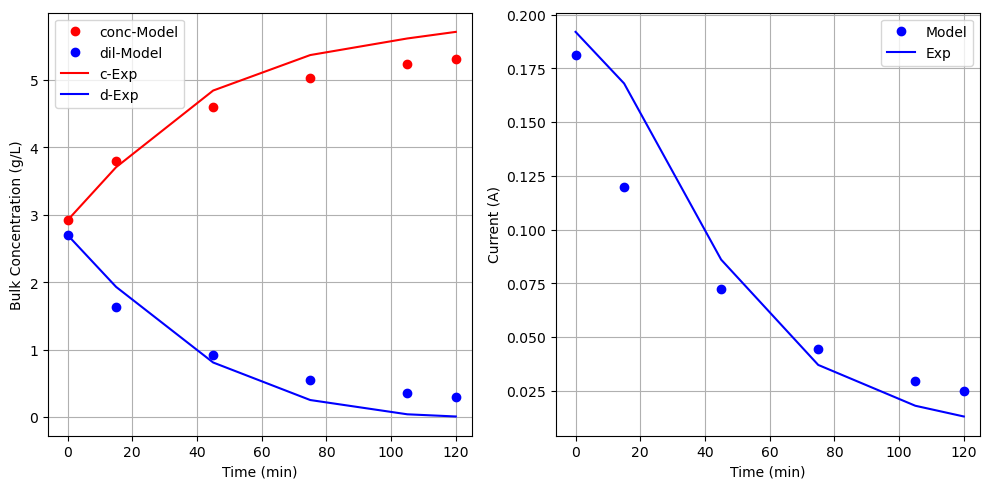

In [35]:
def compute_jEDI(Cconc, Cdil, t, resin, params=[35.45, 4, 3e-3, 1e-3, 14e-4, 4, 298, 1, 1, 0.6, 0.4, 7e-3, 6e-3, 1, 1, 70, 70]):
    F = 96485 # Faraday's constant, C/mol
    R = 8.314 # Gas constant, J/mol-K
    #[MW_Cl, N, Ldil, Lconc, A, Ecell, T, phi, z, t_minus, t_plus, km_dil, km_conc, perm_c, perm_a, Cconc0, Cdil0] = params
    [MW, N, Ldil, Lconc, A, Ecell, T, phi, z, t_minus, t_plus, km_dil, km_conc, perm_c, perm_a, Cconc0, Cdil0] = params

    NaCl = NaclSolution()

    j = 0.001 # A/m2 initial guess
    iteration = 0 # Variable to store the number of iterations
    while True:
        ## A: ******** non-ohmic drop ******** ## 
        # 1. membrane-solution interface
        # km_conc = NaCl.mtc(Q=Qconc, A=A, h=Lconc, c=Cconc, N=N, p=1) # p=1 because it is empty bed
        # km_dil = NaCl.mtc(Q=Qdil, A=A, h=Ldil, c=Cdil, N=N, p=psp) # p=1 because it's not empty bed
        
        Cwadil = Cdil - phi * j / (z * F * km_dil) * (1 - t_minus)
        Cwaconc = Cconc + phi * j / (z * F * km_conc) * (1 - t_minus)
        Cwcdil = Cdil - phi * j / (z * F * km_dil) * (1 - t_plus)
        Cwcconc = Cconc + phi * j / (z * F * km_conc) * (1 - t_plus)
        
        a_conc_wc, a_dil_wc, a_conc_wa, a_dil_wa = NaCl.activity(Cwcconc), NaCl.activity(Cwcdil), NaCl.activity(Cwaconc), NaCl.activity(Cwadil)
        Emem_cem = N * perm_c * (R * T / F) * np.log((a_conc_wc * Cwcconc) / (a_dil_wc * Cwcdil)) #+ N * NaCl.nohm_BL(cDBL=Cwadil, cBULK=Cdil, Temp=T) + N * NaCl.nohm_BL(cDBL=Cwaconc, cBULK=Cconc, Temp=T)
        Emem_aem = N * perm_a * (R * T / F) * np.log((a_conc_wa * Cwaconc) / ( a_dil_wa * Cwadil)) #+ N * NaCl.nohm_BL(cDBL=Cwadil, cBULK=Cdil, Temp=T) + N * NaCl.nohm_BL(cDBL=Cwaconc, cBULK=Cconc, Temp=T)

        Eresin_mem = N * (2*t_minus - 1)*(R * T / F) * np.log((a_dil_wc * Cwcdil)/ (a_dil_wa * Cwadil)) # solution on opposite side of bed

        ## B: ******** ohmic drop ******** ## 
        # 1. diluate, ohm-m2
        R_dil_soln = N * Ldil * 10 / NaCl.solnCond(Cdil) # solution
        R_dil_resin = N * Ldil * 10 / NaCl.resinCond(Cdil, name=resin) # resin
        R_dil = R_dil_soln + R_dil_resin
        # 2. concentrate, ohm-m2
        R_conc = N * Lconc * 10 / NaCl.solnCond(Cdil)
        # 3. membrane
        ra = N * NaCl.AMX(Cdil) # ohm-m2; approx. 2.8e-4
        rc = N * NaCl.CMX(Cdil) # ohm-m2; aprox. 2.5e-4
        # 4. Boundary layer
        EBL_aem = N * (NaCl.ohm_BL(cDBL=Cwadil, cBULK=Cdil, tIEM=1, tBULK=t_minus) + NaCl.ohm_BL(cDBL=Cwaconc, cBULK=Cconc, tIEM=1, tBULK=t_minus))
        EBL_cem = N * (NaCl.ohm_BL(cDBL=Cwcdil, cBULK=Cdil, tIEM=1, tBULK=t_plus) + NaCl.ohm_BL(cDBL=Cwcconc, cBULK=Cconc, tIEM=1, tBULK=t_plus))

        ## current density (A/m2)
        calculated_j = (Ecell - (Emem_cem + Emem_aem + EBL_aem + EBL_cem + Eresin_mem)) / (R_dil + R_conc + ra + rc)
        if abs(calculated_j - j) <= 0.1 or iteration > 10000:
            j = calculated_j
            break

        j = calculated_j
        iteration += 1

    return j # A/m2

def EDI(
                Cconc0 = 70, # Inlet concentrate concentration at inlet at t=0, mol/m3
                Cdil0 = 70, # Inlet diluate concentration at inlet at t=0, mol/m3
                N = 4, # No of cell pairs
                Vconc = 0.25e-3, # concentrate tank volume, m^3; 23-25 mL each
                Vdil = 0.25e-3, # diluate tank volume, m^3
                Qconc = (50*1e-6) / 60, # Flow rate dil. chamber m^3/s
                Qdil = (25*1e-6) / 60, # Flow rate conc. chamber m^3/s
                Da = 5.5e-11, # Avg diffusion coeff of NaCl in AEM (AMX), m^2/s - (M.L. Cerva et al.)
                Dc = 5.5e-11, # Avg diffusion coeff of NaCl in CEM (CMX), m^2/s - (M.L. Cerva et al.)
                La = 0.14e-3, # AEM thickness, m (M.L. Cerva et al.)
                Lc = 0.181e-3, # CEM thickness, m (M.L. Cerva et al.)
                perm_a = 1, # Anionic permselectivity, unitless
                perm_c = 1, # Cationic permselectivity, unitless
                km_dil = 7.4e-04, # diluate mass transfer coefficient, m/s
                km_conc = 1.4e-4, # diluate mass transfer coefficient, m/s
                bt = 1.5e-4, # boundary layer thickness, m (J. Veerman et al. / Journal of Membrane Science 343 (2009) 7–15)
                Ldil = 3e-3, # Diluate channel thickness, m
                Lconc = 1e-3, # Concentrate channel thickness, m
                A  = 14e-4, # Membrane area, m^2
                Ecell = 4, # cell voltage, V
                T_tot = 135 * 60, # Total time s, min * 60
                dt = 1, # Time step, s
                t_eval = None, # array of time, s
                resin_name = 'Mixed-SPEEK', # name of resin
                dp = 570e-6, # resin particle diameter, m  570 ± 50 μm
                kp = 5e-6, # mass transfer coefficient, m/s
                psp = 0.238, # porosity of the resin chamber
                T = 20+273, # Temperature K,
                show_plot = False, # show plot or not
                show_exp=False, # show experimental data or not
                data=None): # Time step, s
    # Constants
    z = 1 # No of electrons transferred
    t_minus, t_plus = 0.61, 0.39 # unitless
    F = 96485 # Faraday's constant, C/mol
    # variables
    Vk_d, Vk_c = A*Ldil, A*Lconc # Diluate & Concentrate compartment volume, m^3
    t_a = 0.5*(perm_a + 1) # unitless
    t_c = 0.5*(perm_c + 1) # unitless
    phi = t_c - (1 - t_a) # Current efficiency
    # set as global variables
    keys = [MW_Cl, N, Ldil, Lconc, A, Ecell, T, phi, z, t_minus, t_plus, km_dil, km_conc, perm_c, perm_a, Cconc0, Cdil0]
    NaCl_m = NaclSolution()

    def dCdt(C, t):
        '''
            params:
                Cconc: Concentrate concentration at outlet
                Cdil: Concentrate concentration at outlet
                Cconc_in: Concentrate concentration at inlet
                Cdil_in: Diluate concentration at inlet
            return:
                DconcDt: 1st diff of Concentrate concentration wrt time
                DdilDt: 1st diff of Diluate concentration wrt time
                Dconc_inDt: 1st diff of Conc concentratn wrt time @ inlet
                Ddil_inDt: 1st diff of Diluate concentration wrt time @ inlet

        '''
        # unpacking the concentrations (mol/m3) array
        Cconc, Cdil, Cdilresin, Cconc_in, Cdil_in = C
        
        # current density in A/m2
        j = compute_jEDI(Cconc=Cconc, Cdil=Cdil, t=t, resin=resin_name, params=keys) 
     
        # concentrations at the membrane-solution interface
        # km_conc = NaCl_m.mtc(Q=Qconc, A=A, h=Lconc, c=Cconc, N=N, p=1) # p=1 because it is empty bed
        # km_dil = NaCl_m.mtc(Q=Qdil, A=A, h=Ldil, c=Cdil, N=N, p=psp) # p=psi because it isnt empty 
        Cwadil = Cdil - phi * j / (z * F * km_dil) * (1 - t_minus)
        Cwaconc = Cconc + phi * j / (z * F * km_conc) * (1 - t_minus)
        Cwcdil = Cdil - phi * j / (z * F * km_dil) * (1 - t_plus)
        Cwcconc = Cconc + phi * j / (z * F * km_conc) * (1 - t_plus)

        # ************ differential equations for the concentrations ************ #
        # bulk solution in concentrate compartment
        DconcDt = (Qconc * (Cconc_in - Cconc) + N * phi * j * A / (z * F)
                        - N * A * Da * (Cwaconc - Cwadil) / La
                        - N * A * Dc * (Cwcconc - Cwcdil) / Lc) / (N * Vk_c) # mol/m3-s
        
        # resin in the diluate compartment
        DdilresinDt = 6*(kp/dp) * (Cdil - Cdilresin) # mol/m3-s
        # bulk solution in diluate compartment
        DdilDt = ((Qdil * (Cdil_in - Cdil)) - (1-psp)*Vk_d*DdilresinDt - (N * phi * j * A / (z * F))
                        + (N * A * Da * (Cwaconc - Cwadil) / La)
                        + (N * A * Dc * (Cwcconc - Cwcdil) / Lc)) / (N * psp * Vk_d) # mol/m3-s
  
        Dconc_inDt = Qconc * (Cconc - Cconc_in)/Vconc # mol/m3-s, concentrate inlet
        Ddil_inDt = Qdil * (Cdil - Cdil_in)/Vdil # mol/m3-s, diluate inlet

        return [DconcDt, DdilDt, DdilresinDt, Dconc_inDt, Ddil_inDt]


    #**************************************Solve Equations**************************************
    # Initial conditions
    initial_conditions = [Cconc0, Cdil0, Cdil0, Cconc0, Cdil0] # Initial conditions for the ODEs

    # Parameters
    print('Simulation started')
    # solve
    print(f'Concentration @ Inlet: Diluate - {Cdil0:.2f}, Concentrate - {Cconc0:.2f}')
    
    if t_eval is None:
        teval = np.arange(0, T_tot+(dt/dt), dt)
    else:
        teval = t_eval

    C = odeint(func=dCdt, y0=np.array(initial_conditions), t=teval)
    print('Simulation completed')


    # **************************************Plot Results**************************************
    createFig = DeviceFigure()
    I=createFig.EDI(C = C, teval=teval, resin_name = resin_name, param = keys, show_exp = show_exp, show_plot = show_plot, data = data, jcompute=compute_jEDI, xlim=(T_tot/60) + 5)

    return C, I, teval, keys

       
ConcEff, current, teval, params = EDI(  Ecell = 4, resin_name = 'AER-CEI', Da=5.5e-11, Dc=5.5e-11,
                                        Cconc0 = Cconc0, Cdil0 = Cdil0, psp = 13.0/100,
                                        kp = 5e-6, km_dil = mk_dil(), km_conc = mk_conc(), 
                                        show_exp = True, data = data, show_plot = True,
                                        T_tot = 120*60, dt = 15*60, t_eval = data['time (min)'].values * 60 
                                        )